# Scaling up drift detection with KeOps

## Introduction

A number of convenient and powerful kernel-based drift detectors such as the MMD detector ([Gretton et al., 2012](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html)) do not scale favourably with increasing dataset size $n$, leading to quadratic complexity $\mathcal{O}(n^2)$ for naive implementations. As a result, we can quickly run into memory issues by having to store the $[N_\text{ref} + N_\text{test}, N_\text{ref} + N_\text{test}]$ kernel matrix (on the GPU if applicable) used for an efficient implementation of the permutation test. Note that $N_\text{ref}$ is the reference data size and $N_\text{test}$ the test data size.

We can however drastically speed up and scale up kernel-based drift detectors to large dataset sizes by working with symbolic kernel matrices instead and leverage the [KeOps](https://www.kernel-operations.io/keops/index.html) library to do so. For the user of $\texttt{Alibi Detect}$ the only thing that changes is the specification of the detector's backend:


```python
from alibi_detect.cd import MMDDrift

detector_torch = MMDDrift(x_ref, backend='pytorch')
detector_keops = MMDDrift(x_ref, backend='keops')
```

In this notebook we will run a few simple benchmarks to illustrate the speed and memory improvements from using KeOps over vanilla PyTorch on the GPU (1x RTX 2080 Ti).

## Data

We randomly sample points from the standard normal distribution and run the MMD detectors with PyTorch and KeOps backends for the following settings:

- $N_\text{ref}, N_\text{test} = [2, 5, 10, 20, 50, 100]$ (batch sizes in '000s)
- $D = [2, 10, 50]$

Where $D$ denotes the number of features.

## Requirements

The notebook requires [PyTorch](https://pytorch.org/) and KeOps to be installed. These are optional dependencies for $\texttt{Alibi Detect}$ and can be installed using:

In [ ]:
!pip install alibi-detect[keops]

Before we start let’s fix the random seeds for reproducibility:

In [1]:
import numpy as np
import torch

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_seed(2022)


## Vanilla PyTorch vs. KeOps comparison

### Experiments

First we define some utility functions to run the experiments:

In [2]:
from alibi_detect.cd import MMDDrift
import matplotlib.pyplot as plt
from scipy.stats import kstest
from timeit import default_timer as timer


def eval_detector(p_vals: np.ndarray, threshold: float, is_drift: bool, t_mean: float, t_std: float) -> dict:
    """ In case of drifted data (ground truth) it returns the detector's power.
    In case of no drift, it computes the false positive rate (FPR) and whether the p-values
    are uniformly distributed U[0,1] which is checked via a KS test. """
    results = {'power': None, 'fpr': None, 'ks': None}
    below_p_val_threshold = (p_vals <= threshold).mean()
    if is_drift:
        results['power'] = below_p_val_threshold
    else:
        results['fpr'] = below_p_val_threshold
        stat_ks, p_val_ks = kstest(p_vals, 'uniform')
        results['ks'] = {'p_val': p_val_ks, 'stat': stat_ks}
    results['p_vals'] = p_vals
    results['time'] = {'mean': t_mean, 'stdev': t_std}
    return results


def experiment(backend: str, n_runs: int, n_ref: int, n_test: int, n_features: int, mu: float = 0.) -> dict:
    """ Runs the experiment n_runs times, each time with newly sampled reference and test data.
    Returns the p-values for each test as well as the mean and standard deviations of the runtimes. """
    p_vals, t_detect = [], []
    for _ in range(n_runs):
        # Sample reference and test data
        x_ref = np.random.randn(*(n_ref, n_features)).astype(np.float32)
        x_test = np.random.randn(*(n_test, n_features)).astype(np.float32) + mu
        
        # Initialise detector, make and log predictions
        p_val = .05
        dd = MMDDrift(x_ref, backend=backend, p_val=p_val, n_permutations=100)
        start = timer()
        pred = dd.predict(x_test)
        end = timer()
        
        if _ > 0:  # first run reserved for KeOps compilation
            t_detect.append(end - start)
            p_vals.append(pred['data']['p_val'])
            
        del dd, x_ref, x_test
        torch.cuda.empty_cache()
    
    p_vals = np.array(p_vals)
    t_mean, t_std = np.array(t_detect).mean(), np.array(t_detect).std()
    results = eval_detector(p_vals, p_val, mu == 0., t_mean, t_std)
    return results


def format_results(n_features: list, backends: list, max_batch_size: int = 1e10) -> dict:
    T = {'batch_size': None, 'keops': None, 'pytorch': None}
    T['batch_size'] = np.unique([experiments['keops'][_]['n_ref'] for _ in experiments['keops'].keys()])
    T['batch_size'] = list(T['batch_size'][T['batch_size'] <= max_batch_size])
    T['keops'] = {f: [] for f in n_features}
    T['pytorch'] = {f: [] for f in n_features}

    for backend in backends:
        for f in T[backend].keys():
            for bs in T['batch_size']:
                for k, v in experiments[backend].items():
                    if f == v['n_features'] and bs == v['n_ref']:
                        T[backend][f].append(results[backend][k]['time']['mean'])

    for k, v in T['keops'].items():  # apply padding
        n_pad = len(v) - len(T['pytorch'][k])
        T['pytorch'][k] += [np.nan for _ in range(n_pad)]
    return T


def plot_absolute_time(results: dict, n_features: list, y_scale: str = 'linear', 
                       detector: str = 'MMD', max_batch_size: int = 1e10):
    T = format_results(n_features, ['keops', 'pytorch'], max_batch_size)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'b']
    legend, n_c = [], 0
    for f in n_features:
        plt.plot(T['batch_size'], T['keops'][f], linestyle='solid', color=colors[n_c]);
        legend.append(f'keops - {f}')
        plt.plot(T['batch_size'], T['pytorch'][f], linestyle='dashed', color=colors[n_c]);
        legend.append(f'pytorch - {f}')
        n_c += 1
    plt.title(f'{detector} drift detection time for 100 permutations')
    plt.legend(legend, loc=(1.1,.1));
    plt.xlabel('Batch size');
    plt.ylabel('Time (s)');
    plt.yscale(y_scale);
    plt.show();


def plot_relative_time(results: dict, n_features: list, y_scale: str = 'linear',
                       detector: str = 'MMD', max_batch_size: int = 1e10):
    T = format_results(n_features, ['keops', 'pytorch'], max_batch_size)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'b']
    legend, n_c = [], 0
    for f in n_features:
        t_keops, t_torch = T['keops'][f], T['pytorch'][f]
        ratio = [tt / tk for tt, tk in zip(t_torch, t_keops)]
        plt.plot(T['batch_size'], ratio, linestyle='solid', color=colors[n_c]);
        legend.append(f'pytorch/keops - {f}')
        n_c += 1
    plt.title(f'{detector} drift detection pytorch/keops time ratio for 100 permutations')
    plt.legend(legend, loc=(1.1,.1));
    plt.xlabel('Batch size');
    plt.ylabel('time pytorch / keops');
    plt.yscale(y_scale);
    plt.show();

As detailed earlier, we will compare the PyTorch with the KeOps implementation of the MMD detector for a variety of reference and test data batch sizes as well as different feature dimensions. Note that for the PyTorch implementation, the portion of the kernel matrix for the reference data itself can already be computed at initialisation of the detector. This computation will not be included when we record the detector's prediction time. Since use cases where $N_\text{ref} >> N_\text{test}$ are quite common, we will also test for this specific setting. The key reason is that we cannot amortise this computation for the KeOps detector since we are working with lazily evaluated symbolic matrices.

#### $N_\text{ref} = N_\text{test}$

Note that for KeOps we could further increase the number of instances in the reference and test sets (e.g. to 500,000) without running into memory issues.

In [3]:
experiments = {
    'keops': {
        0: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 2},
        1: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 2},
        2: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 2},
        3: {'n_ref': 20000, 'n_test': 20000, 'n_runs': 10, 'n_features': 2},
        4: {'n_ref': 50000, 'n_test': 50000, 'n_runs': 10, 'n_features': 2},
        5: {'n_ref': 100000, 'n_test': 100000, 'n_runs': 10, 'n_features': 2},
        6: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 10},
        7: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 10},
        8: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 10},
        9: {'n_ref': 20000, 'n_test': 20000, 'n_runs': 10, 'n_features': 10},
        10: {'n_ref': 50000, 'n_test': 50000, 'n_runs': 10, 'n_features': 10},
        11: {'n_ref': 100000, 'n_test': 100000, 'n_runs': 10, 'n_features': 10},
        12: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 50},
        13: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 50},
        14: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 50},
        15: {'n_ref': 20000, 'n_test': 20000, 'n_runs': 10, 'n_features': 50},
        16: {'n_ref': 50000, 'n_test': 50000, 'n_runs': 10, 'n_features': 50},
        17: {'n_ref': 100000, 'n_test': 100000, 'n_runs': 10, 'n_features': 50}
    },
    'pytorch': {  # runs OOM after 10k instances in ref and test sets
        0: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 2},
        1: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 2},
        2: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 2},
        3: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 10},
        4: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 10},
        5: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 10},
        6: {'n_ref': 2000, 'n_test': 2000, 'n_runs': 10, 'n_features': 50},
        7: {'n_ref': 5000, 'n_test': 5000, 'n_runs': 10, 'n_features': 50},
        8: {'n_ref': 10000, 'n_test': 10000, 'n_runs': 10, 'n_features': 50}
    }
}

In [4]:
backends = ['keops', 'pytorch']
results = {backend: {} for backend in backends}

for backend in backends:
    exps = experiments[backend]
    for i, exp in exps.items():
        results[backend][i] = experiment(
            backend, exp['n_runs'], exp['n_ref'], exp['n_test'], exp['n_features']
        )

Below we visualise the runtimes of the different experiments. We can make the following observations:

- The relative **speed** improvements of KeOps over vanilla PyTorch increase with increasing batch size.

- Due to the explicit kernel computation and storage, the PyTorch detector runs out-of-memory after a little over 10,000 instances in each of the reference and test sets while KeOps keeps **scaling** up without any issues.

- The relative speed improvements decline with growing **feature dimension**. Note however that we would not recommend using a (untrained) MMD detector on very high-dimensional data in the first place.

The plots show both the absolute and relative (PyTorch / KeOps) mean prediction times for the MMD drift detector for different feature dimensions $[2, 10, 50]$.

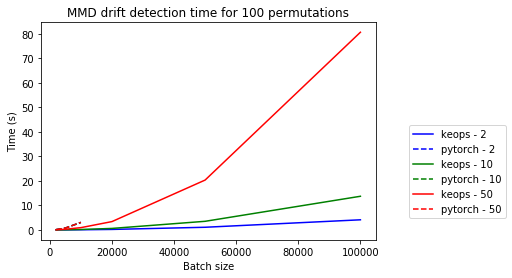

In [5]:
n_features = [2, 10, 50]
max_batch_size = 100000

plot_absolute_time(results, n_features, max_batch_size=max_batch_size)

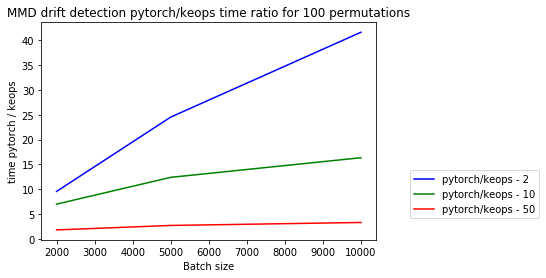

In [6]:
plot_relative_time(results, n_features, max_batch_size=max_batch_size)

The difference between KeOps and PyTorch is even more striking when we only look at $[2, 10]$ features:

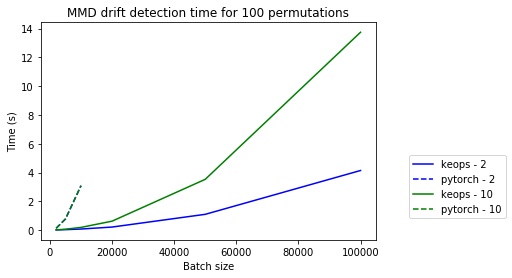

In [7]:
plot_absolute_time(results, [2, 10], max_batch_size=max_batch_size)

#### $N_\text{ref} >> N_\text{test}$

Now we check whether the speed improvements still hold when $N_\text{ref} >> N_\text{test}$ ($N_\text{ref} / N_\text{test} = 10$) and a large part of the kernel can already be computed at initialisation time of the PyTorch  (but not the KeOps) detector.

In [8]:
experiments = {
    'keops': {
        0: {'n_ref': 2000, 'n_test': 200, 'n_runs': 10, 'n_features': 2},
        1: {'n_ref': 5000, 'n_test': 500, 'n_runs': 10, 'n_features': 2},
        2: {'n_ref': 10000, 'n_test': 1000, 'n_runs': 10, 'n_features': 2},
        3: {'n_ref': 20000, 'n_test': 2000, 'n_runs': 10, 'n_features': 2},
        4: {'n_ref': 50000, 'n_test': 5000, 'n_runs': 10, 'n_features': 2},
        5: {'n_ref': 100000, 'n_test': 10000, 'n_runs': 10, 'n_features': 2}
    },
    'pytorch': {
        0: {'n_ref': 2000, 'n_test': 200, 'n_runs': 10, 'n_features': 2},
        1: {'n_ref': 5000, 'n_test': 500, 'n_runs': 10, 'n_features': 2},
        2: {'n_ref': 10000, 'n_test': 1000, 'n_runs': 10, 'n_features': 2}
    }
}

In [9]:
results = {backend: {} for backend in backends}

for backend in backends:
    exps = experiments[backend]
    for i, exp in exps.items():
        results[backend][i] = experiment(
            backend, exp['n_runs'], exp['n_ref'], exp['n_test'], exp['n_features']
        )

The below plots illustrate that KeOps indeed still provides large speed ups over PyTorch. The x-axis shows the reference batch size $N_\text{ref}$. Note that $N_\text{ref} / N_\text{test} = 10$.

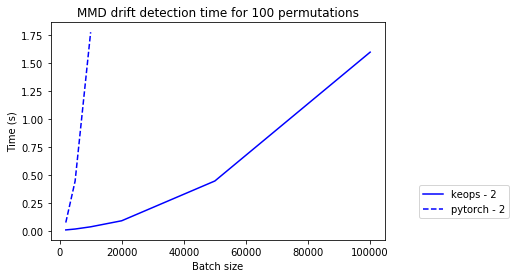

In [10]:
plot_absolute_time(results, [2], max_batch_size=max_batch_size)

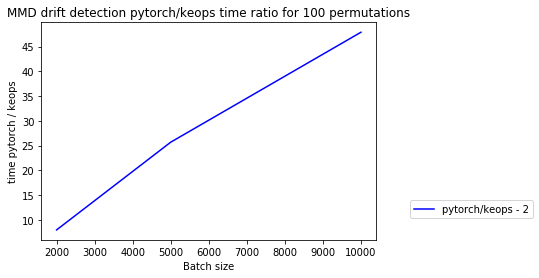

In [11]:
plot_relative_time(results, [2], max_batch_size=max_batch_size)

## Conclusion

As illustrated in the experiments, KeOps allows you to drastically speed up and scale up drift detection to larger datasets without running into memory issues. The speed benefit of KeOps over the PyTorch (or TensorFlow) MMD detector decreases as the number of features increases. Note though that it is not advised to apply the (untrained) MMD detector to very high-dimensional data in the first place.